OSCILADOR ARMÓNICO AMORTIGUADO FORZADO: Diagramas de Poincaré, dimensión fractal y distribución de tiempos

In [64]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import scipy as scipy
from math import *
from tqdm import tqdm
import matplotlib.cm as cm
import matplotlib.colors as colors
import matplotlib as mpl
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.gridspec as gridspec
import os

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


VALORES NUMÉRICOS DEL PROBLEMA

Condiciones iniciales

In [65]:
x_0 = 10 # Posición inicial
v_0 = 0 # Velocidad inicial

Parámetros del sistema

In [66]:
w_0 = 0.5 # Frecuencia natural x>0
W_0 = 8 # Frecuencia natural x<0
amort = 0 # Constante de amortiguamiento
f_0 = 0.25 # Amplitud de la fuerza por unidad de masa

Medida del tiempo

In [67]:
dt = 0.001 # Paso de tiempo
t0 = 0
tf = 1000 # Tiempo de medida
t = np.linspace(0,tf,int(tf/dt)+1) # Vector de instantes de tiempo

Frencuencia angular de la fuerza externa

In [68]:
dw = 0.006 # paso en la frecuencia externa
w =  np.array([i*dw for i in range(int(0.5/dw),int(2/dw)+1)]) # Frecuencia fuerza externa

DEFINIMOS UNA FRECUENCIA NATURAL DEL OSCILADOR QUE DEPENDE DE LA POSICIÓN

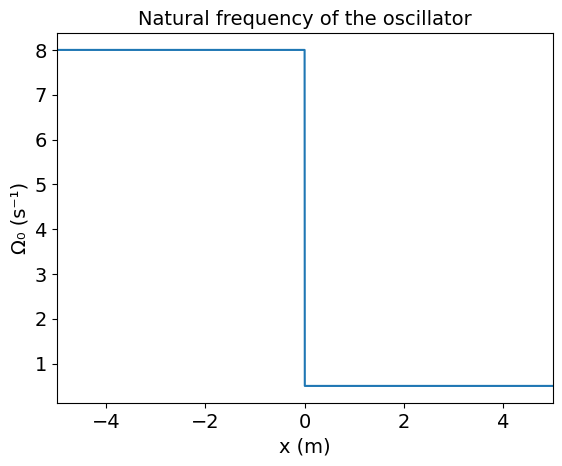

In [69]:
def W(x): # frecuecia angular
    return W_0 - (W_0-w_0)*np.heaviside(x,w_0)

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
rep = np.linspace(-5,5,5000)
plt.plot(rep,W(rep)) # Representación gráfica de la frecuencia natural
plt.title('Natural frequency of the oscillator',fontsize = 14)
plt.xlabel('x (m)',fontsize = 14)
plt.ylabel('Ω₀ (s⁻¹)',fontsize = 14)
plt.xlim([min(rep),max(rep)])
#plt.savefig('Frecuencia natural.png')
plt.show()

POTENCIAL DEL OSCILADOR

In [70]:
def W2(x,W_0,w_0): # frecuecia angular
    return W_0 - (W_0-w_0)*np.heaviside(x,w_0)

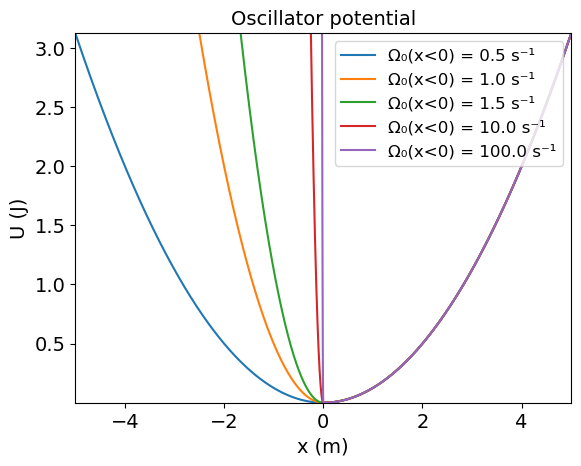

In [71]:
rep = np.linspace(-5,5,5000)
U = (1/2)*W2(rep,w_0,w_0)**2*rep**2
U2 = (1/2)*W2(rep,w_0+0.5,w_0)**2*rep**2
U3 = (1/2)*W2(rep,w_0+1,w_0)**2*rep**2
U4 = (1/2)*W2(rep,w_0+9.5,w_0)**2*rep**2
U5 = (1/2)*W2(rep,w_0+99.5,w_0)**2*rep**2

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)
plt.plot(rep,U,label = 'Ω₀(x<0) = '+str(format(w_0,'.1f'))+' s⁻¹')
plt.plot(rep,U2,label = 'Ω₀(x<0) = '+str(format(w_0+0.5,'.1f'))+' s⁻¹')
plt.plot(rep,U3,label = 'Ω₀(x<0) = '+str(format(w_0+1,'.1f'))+' s⁻¹')
plt.plot(rep,U4,label = 'Ω₀(x<0) = '+str(format(w_0+9.5,'.1f'))+' s⁻¹')
plt.plot(rep,U5,label = 'Ω₀(x<0) = '+str(format(w_0+99.5,'.1f'))+' s⁻¹')

plt.title('Oscillator potential',fontsize = 14)
plt.xlabel('x (m)',fontsize = 14)
plt.ylabel('U (J)',fontsize = 14)
plt.xlim([min(rep),max(rep)])
plt.ylim([min(U),(1/2)*W2(max(rep),w_0,w_0)**2*max(rep)**2])
plt.legend(loc = 'upper right',fontsize = 12)
#plt.savefig('Figura potencial del oscilador.png')
plt.show()

ECUACIÓN DIFERENCIAL

In [72]:
def EDO(t,y,w): # classical eqs.
    x,v = y
    return [v,-2*amort*v-W(x)**2*x+f_0*np.cos(w*t)]

CÁLCULO DEL MOVIMIENTO DEL SISTEMA

Integración de la EDO

In [73]:
def time_intervals(x):
    v = x.copy()
    bin = v[1:(t.size-1)]
    bin[[v[i]*v[i-1]>0 for i in range(1,t.size-1)]] = 0
    bin[bin<0] = -1
    bin[bin>0] = 1
    v[v.size-1] = -1

    tindpos = np.where(v > 0)[0]
    tindneg = np.where(v < 0)[0]

    if np.size(tindpos) > np.size(tindneg):
        tindpos = np.delete(tindpos,int(np.size(tindpos))-1)
    if np.size(tindpos) < np.size(tindneg):
        tindneg = np.delete(tindneg,int(np.size(tindneg))-1)

    return (tindneg-tindpos)[1:(len(tindneg-tindpos)-1)]*dt

In [74]:
def RK4(EDO, x0, y0, xf, h, w):

    # EDO: Array de ecuaciones diferenciales de primer orden
    # x0: valor inicial de la variable independiente
    # y0: valor de la variable dependiente evaluada en x = x0 (condición inicial si x=0)
    # xf: valor final de la variable independiente
    # h: tamaño del paso

    n = int((xf-x0)/h)+1 # Calculamos el número de puntos
    m = 2
    
    x = np.empty(n) # Creamos arrays donde almacenar la solución
    y = np.empty([n,m])
    k1,k2,k3,k4= np.empty(m),np.empty(m),np.empty(m),np.empty(m)

    x[0] = x0 # Aplicamos las condiciones iniciales
    for j in range(m):
        y[0,j] = y0[j]
    
    for i in range(n-1): # Implementamos el método RK4
        x[i] = x0+i*h
        for j in range(m):
            k1[j] = h*EDO(x[i],y[i,:],w)[j]
        for j in range(m):
            k2[j] = h*EDO(x[i]+0.5*h,y[i]+0.5*k1,w)[j]
        for j in range(m):
            k3[j] = h*EDO(x[i]+0.5*h,y[i]+0.5*k2,w)[j]
        for j in range(m):
            k4[j] = h*EDO(x[i]+h,y[i]+k3,w)[j]
        for j in range(m):
            y[i+1,j] = y[i,j]+(1/6)*(k1[j]+2*k2[j]+2*k3[j]+k4[j]);

    x[n-1] = xf
            
    return x,y

In [75]:
pos = []
vel = []
xp = []
vp = []
tdist = []

for i in tqdm(range(np.size(w))):

    t,y = RK4(EDO,t0,[x_0,v_0],tf,dt,w[i]) # Resolvemos el sistema

    xc = y[:,0]
    vc = y[:,1]
    pos.append(xc)
    vel.append(vc)

    T = 2*np.pi/w[i] # Periodo fuerza externa
    Np = int(tf/T) # Número de puntos del diagrama de Poincaré
    ind = np.array([np.searchsorted(t,T*(i+1)) for i in range(Np-1)]) # Calculamos los índices del diagrama de Poincaré
    xp.append(xc[ind]) # Asignamos índices encontrados en tiempos con posiciones y velocidades (/max(x[ind]))
    vp.append(vc[ind])

    tdist.append(time_intervals(pos[i])) # Calculamos los intervalos de tiempo entre choques

100%|██████████| 251/251 [5:38:50<00:00, 81.00s/it]  


CÁLCULO DE LOS EXPONENTES DE LYAPUNOV

In [76]:
def Lyapunov_exponent(EDO,dt,tf,w,eps,x_0,v_0):

    N = int((tf-t0)/dt)+1
    
    z = np.zeros([N,2])
    zp = np.zeros([N,2])
    d = np.zeros(N)
    loglist = np.zeros(N)

    z[0] = [x_0,v_0]
    zp[0] = [x_0+eps/np.sqrt(2),v_0+eps/np.sqrt(2)]
    d[0] = eps
   
    t,y = RK4(EDO,0,z[0],tf,dt,w) # Resolvemos el sistema
    tL,yL = RK4(EDO,0,zp[0],tf,dt,w) # Resolvemos el sistema
    pos = y[:,0]
    vel = y[:,1]
    posL = yL[:,0]
    velL = yL[:,1]

    for i in range(1,N):
        z[i] = [pos[i],vel[i]]
        zp[i] = [posL[i],velL[i]]
        d[i] = np.linalg.norm((z[i]-zp[i]))
        loglist[i] = np.log(d[i]/eps)

    return [np.mean((loglist/t)[-int(N/5):]),np.std((loglist/t)[-int(N/5):])]

In [77]:
lyap = np.zeros(np.size(w))
disp = np.zeros(np.size(w))
eps = 1e-2

for i in tqdm(range(np.size(w))):
    lyap[i],disp[i] = Lyapunov_exponent(EDO,dt,tf,w[i],eps,x_0,v_0)

  0%|          | 0/251 [00:00<?, ?it/s]C:\Users\rodri\AppData\Local\Temp\ipykernel_20424\157573481.py:27: RuntimeWarning: invalid value encountered in divide
  return [np.mean((loglist/t)[-int(N/5):]),np.std((loglist/t)[-int(N/5):])]
100%|██████████| 251/251 [8:53:30<00:00, 127.53s/it]  


DISTRIBUCIÓN DE INTERVALOS DE TIEMPO

In [78]:
num_bin = 8000
tdist_hist = np.zeros([w.size,num_bin])

for i in range(w.size):
    tdist_hist[i,:] = np.histogram(tdist[i], bins = num_bin, range = [4.5,8], density = True)[0]

GUARDAMOS LOS DATOS

In [79]:
newpath = r'.\xp' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

newpath = r'.\vp' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

newpath = r'.\tdist' 
if not os.path.exists(newpath):
    os.makedirs(newpath)

In [80]:
for i in range(w.size):
    np.savetxt(r'.\xp/xp ω = '+str(format(w[i],'.3f'))+'.txt',xp[i])
    np.savetxt(r'.\vp/vp ω = '+str(format(w[i],'.3f'))+'.txt',vp[i])
    np.savetxt(r'.\tdist/tdist ω = '+str(format(w[i],'.3f'))+'.txt',tdist_hist[i])

In [81]:
explyap = np.column_stack([lyap,disp,w])
np.savetxt('explyap.txt',explyap)

CARGAMOS LOS DATOS

In [88]:
xp = []
vp = []

for i in range(w.size):
    b = open(r'.\xp/xp ω = '+str(format(w[i],'.3f'))+'.txt','r')
    c = open(r'.\vp/vp ω = '+str(format(w[i],'.3f'))+'.txt','r')
    XP = b.readlines()
    VP = c.readlines()
    for j in range(len(XP)):
        XP[j] = float((XP[j].split())[0])
        VP[j] = float((VP[j].split())[0])
    xp.append(XP)
    vp.append(VP)

b.close()
c.close()

In [89]:
num_bin = 8000
tdist_hist = np.zeros([w.size,num_bin])

for i in range(w.size):
    d = open(r'.\tdist/tdist ω = '+str(format(w[i],'.3f'))+'.txt','r')
    tdist_hist[i:] = d.readlines()

d.close()

In [90]:
e = open('explyap.txt','r')

explyap = e.readlines()
lyap = np.zeros(w.size)
disp = np.zeros(w.size)

for i in range(w.size):
    explyap[i] = explyap[i].split()
    lyap[i] = explyap[i][0]
    disp[i] = explyap[i][1]

e.close()

REPRESENTACIÓN GRÁFICA

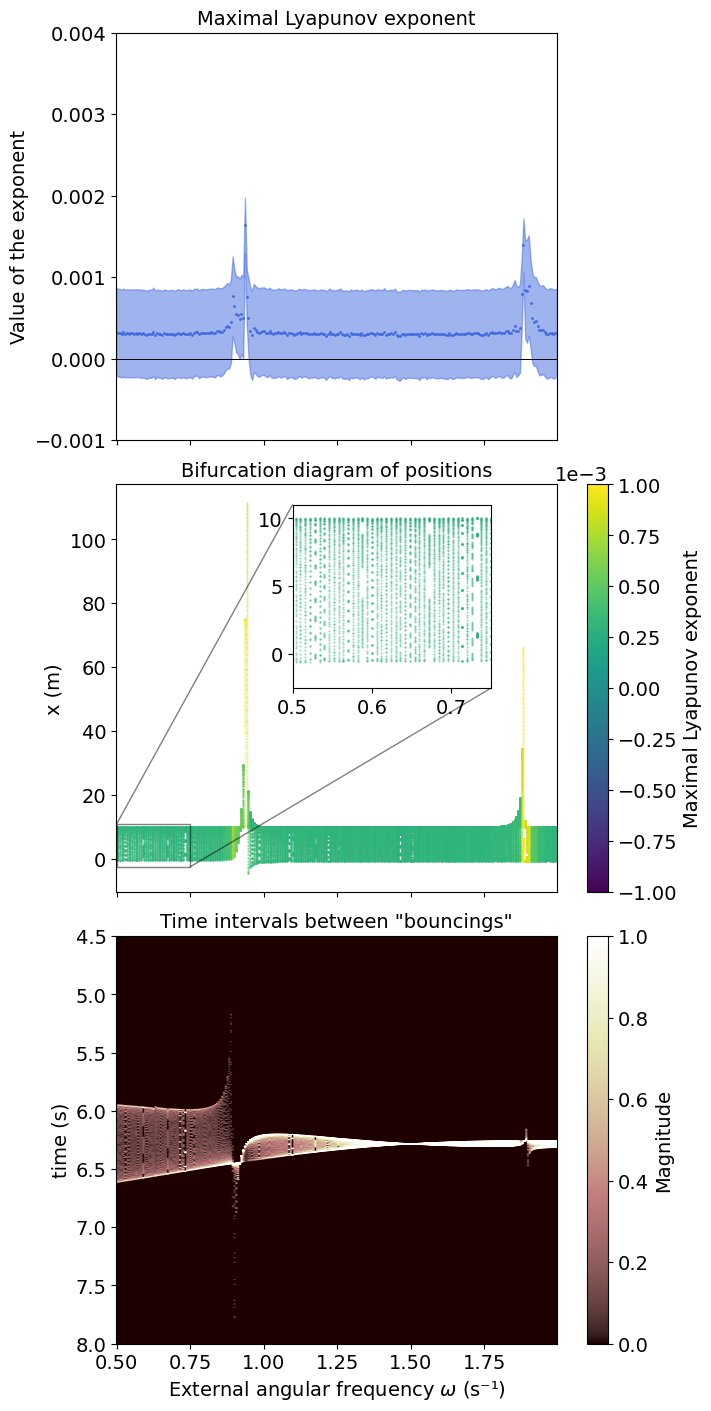

In [99]:
fig1,(ax1,ax2,ax3) = plt.subplots(3,1, figsize=(7, 14), sharex = True, constrained_layout=True)

plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

ax1.fill_between(w,lyap-disp,lyap+disp,alpha = 0.5,color ='royalblue')
ax1.plot(w,lyap,'.', markersize = '2', color = 'royalblue')
ax1.plot(w,[0]*w.size,color = 'black',linewidth = '.7')
ax1.set_ylabel('Value of the exponent',fontsize = 14)
ax1.set_title('Maximal Lyapunov exponent',fontsize = 14)
ax1.set_xlim(min(w),max(w))
ax1.set_ylim(-0.001,0.004)

norm = colors.Normalize(vmin=-0.001, vmax=0.001)
f2rgb = cm.ScalarMappable(norm=norm, cmap=cm.get_cmap('viridis'))

for i in range(w.size):
    ax2.plot(w[i]*np.ones(np.size(xp[i])),np.array(xp[i],dtype=object),'.',markersize=1,alpha=0.5,color=f2rgb.to_rgba(lyap[i])[:3])
ax2.set_ylabel('x (m)', fontsize = 14)
ax2.set_xlim(min(w),max(w))
axins = ax2.inset_axes([0.4, 0.5, 0.45, 0.45])
for i in range(w.size):
    axins.plot(w[i]*np.ones(np.size(xp[i])),np.array(xp[i],dtype=object),'.',markersize=1,alpha=0.5,color=f2rgb.to_rgba(lyap[i])[:3])
x1, x2, y1, y2 = 0.5, 0.75, -2.5, 11
axins.set_xlim(x1, x2)
axins.set_ylim(y1, y2)
ax2.indicate_inset_zoom(axins, edgecolor="black")
#ax2.set_ylim(-0.2,0.5)
ax2.set_title('Bifurcation diagram of positions',fontsize = 14)
cbar = plt.colorbar(f2rgb, ax = ax2,  pad = -0.005)
cbar.set_label('Maximal Lyapunov exponent',fontsize = 14)
cbar.formatter.set_powerlimits((0, 0))

im = ax3.imshow(np.transpose(tdist_hist)/10,cmap = 'pink',vmin = 0, vmax = 1, aspect = 'auto', extent = [min(w),max(w),8,4.5])
cbar2 = plt.colorbar(im, ax = ax3, pad = 0.069)
cbar2.set_label('Magnitude', fontsize = 14)
ax3.set_ylabel('time (s)',fontsize = 14)
ax3.set_xlabel('External angular frequency $\omega$ (s⁻¹)',fontsize = 14)
ax3.set_title('Time intervals between "bouncings"',fontsize = 14)

fig1.savefig('fig.png',dpi=250)

In [92]:
def update_fig(num,xp,vp):
    ax9.cla()
    ax10.cla()
    ax11.cla()
    
    ax10.plot(xp[num][:],vp[num][:],'.',color=f2rgb.to_rgba(lyap[num])[:3],markersize='1')
    for i in range(w.size):
        ax11.plot(np.array(xp[i],dtype=object)[:],w[i]*np.ones(np.size(xp[i])),'.',color=f2rgb.to_rgba(lyap[i])[:3],markersize='1',alpha=0.5)
        ax9.plot(w[i]*np.ones(np.size(xp[i])),np.array(vp[i],dtype=object)[:],'.',color=f2rgb.to_rgba(lyap[i])[:3],markersize='1',alpha=0.5)
    ax11.plot([-7,40],[w[num],w[num]], color = 'red')
    ax9.plot([w[num],w[num]],[-40,40], color = 'red')

    ax10.set_xlim([-7,40])
    ax10.set_ylim([-40,40])
    ax10.set_title('Evolution of the Poincare section with ω',fontsize = 14)
    ax10.set_xlabel('x (m)',fontsize = 14)
    ax10.set_ylabel('v (m/s)',fontsize = 14)
    fig4.suptitle('ω = '+str(format(w[num],'.3f'))+' s⁻¹', y = 0.925,fontsize = 14)
    ax11.set_ylabel('ω (s⁻¹)',fontsize = 14)
    ax11.set_xlabel('x (m)',fontsize = 14)
    ax11.set_ylim([min(w),max(w)])
    ax11.set_xlim([-7,40])
    ax11.set_title('Bifurcation diagram of positions',fontsize = 14)
    ax11.invert_yaxis()
    ax9.set_xlabel('ω (s⁻¹)',fontsize = 14)
    ax9.set_ylabel('v (m/s)',fontsize = 14)
    ax9.set_xlim([min(w),max(w)])
    ax9.set_ylim([-40,40])
    ax9.set_title('Bifurcation diagram of velocities',fontsize = 14)
    ax9.invert_xaxis()

C:\Users\rodri\AppData\Local\Temp\ipykernel_20424\619896956.py:20: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  animP.save('fig2.gif')
C:\Users\rodri\AppData\Local\Temp\ipykernel_20424\619896956.py:21: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  animP.save('fig2.mp4')
c:\Users\rodri\anaconda3\envs\QuantumChaos\lib\site-packages\IPython\core\pylabtools.py:151: UserWarning: There are no gridspecs with layoutgrids. Possibly did not call parent GridSpec with the "figure" keyword
  fig.canvas.print_figure(bytes_io, **kw)


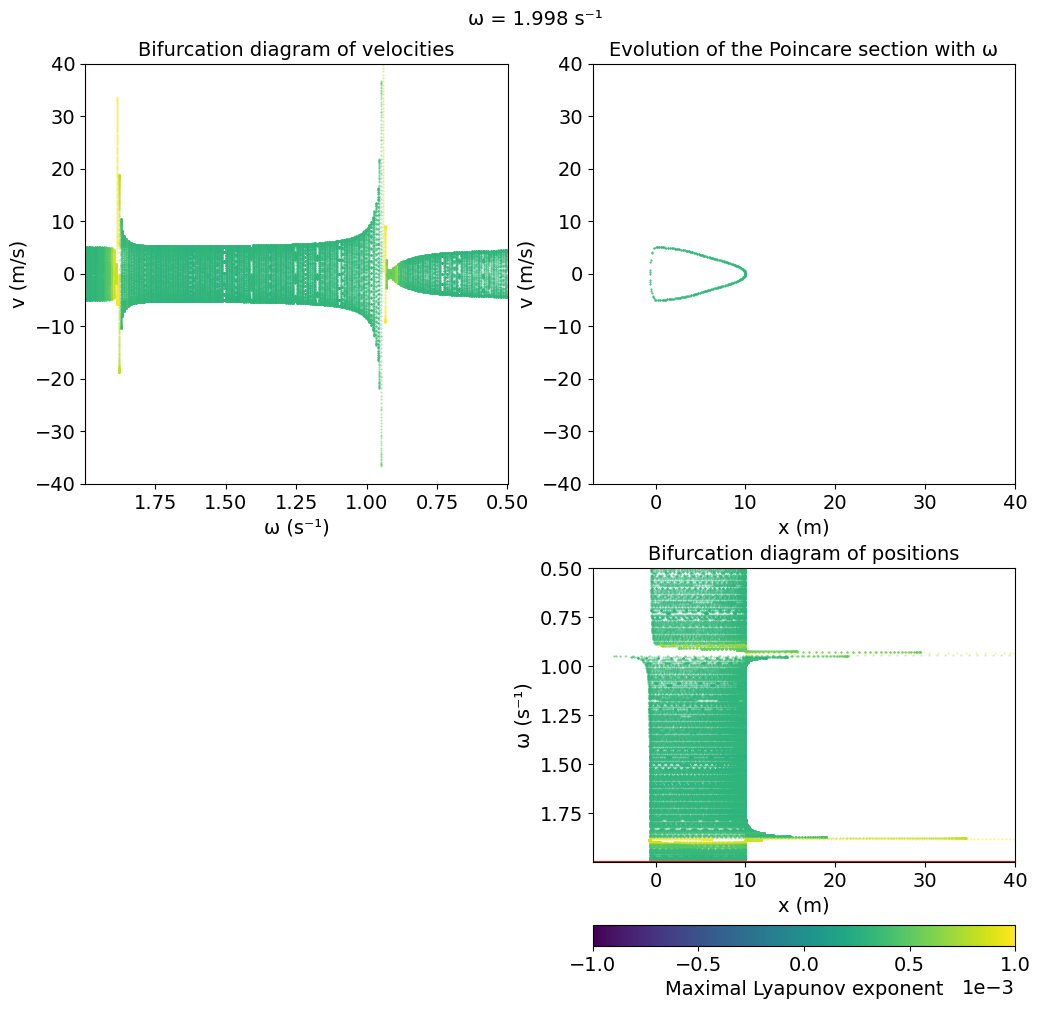

In [93]:
#fig4,(ax9,ax10,ax11) = plt.subplots(2,2, figsize=(16, 6), constrained_layout = True)
fig4 = plt.figure(figsize=(12,12), constrained_layout=True)

gs = gridspec.GridSpec(2, 4)
gs.update(wspace=0.5)
ax9 = plt.subplot(gs[0, :2])
ax10 = plt.subplot(gs[0, 2:])
ax11 = plt.subplot(gs[1, 2:])
ax10.plot(xp[0][:],vp[0][:],'.',color=f2rgb.to_rgba(lyap[0])[:3],markersize='1')
for i in range(w.size):
    ax11.plot(np.array(xp[i],dtype=object)[:],w[i]*np.ones(np.size(xp[i])),'.',color=f2rgb.to_rgba(lyap[i])[:3],markersize='1',alpha=0.5)
    ax9.plot(w[i]*np.ones(np.size(xp[i])),np.array(vp[i],dtype=object)[:],'.',color=f2rgb.to_rgba(lyap[i])[:3],markersize='1',alpha=0.5)
ax11.plot([-7,40],[w[0],w[0]], color = 'red')
ax9.plot([w[0],w[0]],[-40,40], color = 'red')
cbar = plt.colorbar(f2rgb, ax = ax11,  pad = 0.15, orientation="horizontal" )
cbar.set_label('Maximal Lyapunov exponent',fontsize = 14)
cbar.formatter.set_powerlimits((0, 0))

animP = animation.FuncAnimation(fig4, update_fig, np.size(w), fargs = (xp,vp, ), interval = 20)
animP.save('fig2.gif')
animP.save('fig2.mp4')